In [1]:
import tensorflow as tf
import tensorflow_probability as tfp
import tensorflow.math as tm
import numpy as np
import time
import matplotlib.pyplot as plt

from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras import initializers
from tensorflow.keras import Model
from tensorflow.keras import models
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Sequential
from sklearn.metrics import accuracy_score
from sklearn.datasets import make_moons
from sklearn.model_selection import train_test_split

In [2]:
def convert2_zero_one(x):
    
    t = [tf.math.sigmoid(i) for i in x]    
    return t

def cont_bern_log_norm(lam, l_lim=0.49, u_lim=0.51):
    '''
    computes the log normalizing constant of a continuous Bernoulli distribution in a numerically stable way.
    returns the log normalizing constant for lam in (0, l_lim) U (u_lim, 1) and a Taylor approximation in
    [l_lim, u_lim].
    cut_y below might appear useless, but it is important to not evaluate log_norm near 0.5 as tf.where evaluates
    both options, regardless of the value of the condition.
    '''
    
    cut_lam = tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), lam, l_lim * tf.ones_like(lam))
    log_norm = tm.log(tm.abs(2.0 * tm.atanh(1 - 2.0 * cut_lam))) - tm.log(tm.abs(1 - 2.0 * cut_lam))
    taylor = tm.log(2.0) + 4.0 / 3.0 * tm.pow(lam - 0.5, 2) + 104.0 / 45.0 * tm.pow(lam - 0.5, 4)
    return tf.where(tm.logical_or(tm.less(lam, l_lim), tm.greater(lam, u_lim)), log_norm, taylor)

In [3]:
class StochasticMLP(Model):
    
    def __init__(self, hidden_layer_sizes=[100], n_outputs=10, lr=1e-3):
        super(StochasticMLP, self).__init__()
        self.hidden_layer_sizes = hidden_layer_sizes
        self.fc_layers = [Dense(layer_size) for layer_size in hidden_layer_sizes]
        self.output_layer = Dense(n_outputs)
        self.optimizer = tf.keras.optimizers.Adam(learning_rate = lr)
        
    def call(self, x):
        
        network = []
        
        for i, layer in enumerate(self.fc_layers):
            
            logits = layer(x)
            x = tfp.distributions.Bernoulli(logits=logits).sample()
            network.append(x)

        final_logits = self.output_layer(x) # initial the weight of output layer
            
        return network
    
    def target_log_prob(self, x, h, y, is_gibbs = False, is_hmc = False, is_loss = False):
        
        # get current state
        if is_hmc:
            h_current = tf.split(h, self.hidden_layer_sizes, axis = 1)
        else:    
            h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h]
        h_current = convert2_zero_one(h_current)
        h_previous = [x] + h_current[:-1]
    
        nlog_prob = 0. # negative log probability
        
        if not is_loss:
            for i, (cv, pv, layer) in enumerate(zip(h_current, h_previous, self.fc_layers)):
            
                logits = layer(pv)
                ce = tf.nn.sigmoid_cross_entropy_with_logits(labels = cv, logits = logits)
                if not is_gibbs:
                    ce += cont_bern_log_norm(tf.nn.sigmoid(logits))
            
                nlog_prob += tf.reduce_sum(ce, axis = -1)
        
        fce = tf.nn.sigmoid_cross_entropy_with_logits(
            labels=tf.cast(y, tf.float32), logits=self.output_layer(h_current[-1]))
        nlog_prob += tf.reduce_sum(fce, axis = -1)
            
        return -1 * nlog_prob
    
    def gibbs_new_state(self, x, h, y):
        
        '''
            generate a new state for the network node by node in Gibbs setting.
        '''
        
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        
        in_layers = self.fc_layers
        out_layers = self.fc_layers[1:] + [self.output_layer]
        
        prev_vals = [x] + h_current[:-1]
        curr_vals = h_current
        next_vals = h_current[1:] + [y]
        
        for i, (in_layer, out_layer, pv, cv, nv) in enumerate(zip(in_layers, out_layers, prev_vals, curr_vals, next_vals)):

            # node by node
            
            nodes = tf.transpose(cv)
            prob_parents = tm.sigmoid(in_layer(pv))
            
            out_layer_weights = out_layer.get_weights()[0]
            
            next_logits = out_layer(cv)
            
            new_layer = []
            
            for j, node in enumerate(nodes):
                
                # get info for current node (i, j)
                
                prob_parents_j = prob_parents[:, j]
                out_layer_weights_j = out_layer_weights[j]
                
                # calculate logits and logprob for node is 0 or 1
                next_logits_if_node_0 = next_logits[:, :] - node[:, None] * out_layer_weights_j[None, :]
                next_logits_if_node_1 = next_logits[:, :] + (1 - node[:, None]) * out_layer_weights_j[None, :]
                
                #print(next_logits_if_node_0, next_logits_if_node_1)
                
                logprob_children_if_node_0 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.cast(nv, dtype = tf.float32), logits=next_logits_if_node_0), axis = -1)
                
                logprob_children_if_node_1 = tf.reduce_sum(tf.nn.sigmoid_cross_entropy_with_logits(
                    labels=tf.cast(nv, dtype = tf.float32), logits=next_logits_if_node_1), axis = -1)
                
                # calculate prob for node (i, j)
                prob_0 = (1 - prob_parents_j) * tm.exp(logprob_children_if_node_0)
                prob_1 = prob_parents_j * tm.exp(logprob_children_if_node_1)
                prob_j = prob_1 / (prob_1 + prob_0)
            
                # sample new state with prob_j for node (i, j)
                new_node = tfp.distributions.Bernoulli(probs = prob_j).sample() # MAY BE SLOW
                
                # update nodes and logits for following calculation
                new_node_casted = tf.cast(new_node, dtype = "float32")
                next_logits = next_logits_if_node_0 * (1 - new_node_casted)[:, None] \
                            + next_logits_if_node_1 * new_node_casted[:, None] 
                
                # keep track of new node values (in prev/curr/next_vals and h_new)
                new_layer.append(new_node)
           
            new_layer = tf.transpose(new_layer)
            h_current[i] = new_layer
            prev_vals = [x] + h_current[:-1]
            curr_vals = h_current
            next_vals = h_current[1:] + [y]
        
        return h_current
    
    def generate_hmc_kernel(self, x, y, step_size = pow(1000, -1/4)):
        
        adaptive_hmc = tfp.mcmc.SimpleStepSizeAdaptation(tfp.mcmc.HamiltonianMonteCarlo(
            target_log_prob_fn = lambda v: self.target_log_prob(x, v, y, is_hmc = True),
            num_leapfrog_steps = 2,
            step_size = step_size),
            num_adaptation_steps=int(100 * 0.8))
        
        return adaptive_hmc
    
    # new proposing-state method with HamiltonianMonteCarlo
    def propose_new_state_hamiltonian(self, x, h, y, hmc_kernel, is_update_kernel = True):
    
        h_current = h
        h_current = [tf.cast(h_i, dtype=tf.float32) for h_i in h_current]
        h_current = tf.concat(h_current, axis = 1)

        # run the chain (with burn-in)
        num_burnin_steps = 0
        num_results = 1

        samples = tfp.mcmc.sample_chain(
            num_results = num_results,
            num_burnin_steps = num_burnin_steps,
            current_state = h_current, # may need to be reshaped
            kernel = hmc_kernel,
            trace_fn = None,
            return_final_kernel_results = True)
    
        # Generate new states of chains
        #h_state = rerange(samples[0][0])
        h_state = samples[0][0]
        h_new = tf.split(h_state, self.hidden_layer_sizes, axis = 1) 
        
        # Update the kernel if necesssary
        if is_update_kernel:
            new_step_size = samples[2].new_step_size.numpy()
            ker_new = self.generate_hmc_kernel(x, y, new_step_size)
            return(h_new, ker_new)
        else:
            return h_new
    
    def update_weights(self, x, h, y, is_gibbs = False):
        
        with tf.GradientTape() as tape:
            loss = -1 * tf.reduce_mean(self.target_log_prob(x, h, y, is_gibbs = is_gibbs))
        
        grads = tape.gradient(loss, self.trainable_weights)
        self.optimizer.apply_gradients(zip(grads, self.trainable_weights))
    
    def get_predictions(self, x):

        logits = 0.0
        for layer in self.fc_layers:
            logits = layer(x)
            x = tm.sigmoid(logits)
        
        logits = self.output_layer(x)
        probs = tm.sigmoid(logits)
        #print(probs)
        labels = tf.cast(tm.greater(probs, 0.5), tf.int32)

        return labels

In [4]:
def standard_backprop(size, dat_train, dat_val, epochs):
    '''
    Standard Backpropogation training
    '''
    
    batch_size = 4
    
    print("Start Standard Backprop")
    model = keras.Sequential(
        [
            layers.InputLayer(input_shape=(2,)),
            layers.Dense(size, activation = "sigmoid"),
            layers.Dense(1, activation = "sigmoid")
        ]
    )   
    opt = tf.keras.optimizers.Adam(learning_rate=0.01)
    st = time.time()
    model.compile(loss = "binary_crossentropy", optimizer = opt, metrics = ["accuracy"])
    history = model.fit(dat_train, batch_size = batch_size, epochs = epochs, validation_data = dat_val)
    train_time = time.time() - st
    
    return train_time, history

In [5]:
def hmc(size, dat_train, dat_val, epochs):
    '''
    HMC training
    '''
    # Setting
    # Get train labels and val labels
    target_train = np.concatenate([target for data, target in dat_train.as_numpy_iterator()])
    target_val = np.concatenate([target for data, target in dat_val.as_numpy_iterator()])
    
    print("Start HMC")
    model = StochasticMLP(hidden_layer_sizes = [size], n_outputs = 1, lr = 0.01)
    network = [model.call(data) for data, target in dat_train]
    kernels = [model.generate_hmc_kernel(data, target) for data, target in dat_train]  
    
    # Burnin
    print("Start HMC Burning")
    burnin = 500
    burnin_losses = []
    for i in range(burnin):
        
        if(i % 100 == 0): print("Step %d" % i)

        res = []
        burnin_loss = 0.0
        for bs, (data, target) in enumerate(dat_train):
            res.append(model.propose_new_state_hamiltonian(data, network[bs], target, kernels[bs]))
            burnin_loss += -1 * tf.reduce_sum(model.target_log_prob(data, network[bs], target))
    
        network, kernels = zip(*res)
        burnin_losses.append(burnin_loss / (bs + 1))
    
    # Training
    print("Start HMC Training")
    train_losses = []
    train_accs = []
    val_losses = []
    val_accs = []
    start_time = time.time()
    
    for epoch in range(epochs):
        
        # train
        for bs, (data, target) in enumerate(dat_train):
        
            model.update_weights(data, network[bs], target)
            network = [model.propose_new_state_hamiltonian(x, net, y, ker, is_update_kernel = False) \
                       for (x, y), net, ker in zip(dat_train, network, kernels)]
            
        train_loss = 0.0
        for bs, (data, target) in enumerate(dat_train):
            train_loss += -1 * tf.reduce_mean(model.target_log_prob(data, network[bs], target, is_loss = True))
        train_loss /= (bs + 1)
        train_losses.append(train_loss)       
        
        train_preds = [model.get_predictions(data) for data, target in dat_train]
        train_acc = accuracy_score(np.concatenate(train_preds), target_train)
        train_accs.append(train_acc)        
        
        # validate
        
        network_val = [model.call(data) for data, target in dat_val]
        val_loss = 0.0
        for bs, (data, target) in enumerate(dat_val):
            val_loss += -1 * tf.reduce_mean(model.target_log_prob(data, network_val[bs], target, is_loss = True))
        val_loss /= (bs + 1)
        val_losses.append(val_loss)  
        
        val_preds = [model.get_predictions(data) for data, target in dat_val]
        val_acc = accuracy_score(np.concatenate(val_preds), target_val)
        val_accs.append(val_acc)
        
        print("Epoch %d/%d: - %.4fs/step - train_loss: %.4f - train_acc: %.4f - val_loss: %.4f - val_acc: %.4f" 
            % (epoch + 1, epochs, (time.time() - start_time) / (epoch + 1), train_loss, train_acc, val_loss, val_acc))

    train_time = time.time() - start_time
    return burnin_losses, train_time, {"train_acc": train_accs, "train_loss": train_losses,
                             "val_acc": val_accs, "val_loss": val_losses}

In [6]:
np.random.seed(1234)
X, Y = make_moons(200, noise = 0.3)

# Split into test and training data
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size = 0.2, random_state=73)
y_train = y_train.reshape(-1, 1)
y_val = y_val.reshape(-1, 1)

train_ds = tf.data.Dataset.from_tensor_slices((x_train, y_train)).batch(32)
val_ds = tf.data.Dataset.from_tensor_slices((x_val, y_val)).batch(32)

2021-12-13 16:40:42.310364: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


In [7]:
model_size = [32]
for size in model_size:
    
    epochs = 200
    time_bp, history_bp = standard_backprop(size, train_ds, val_ds, epochs)
    burnin_loss_hmc, time_hmc, history_hmc = hmc(size, train_ds, val_ds, epochs)
    #tlp_burnin_gibbs, time_gibbs, history_gibbs = gibbs(size, train_ds, epochs)

Start Standard Backprop
Epoch 1/200
1/5 [=====>........................] - ETA: 1s - loss: 0.6254 - accuracy: 0.6250

2021-12-13 16:40:43.111788: I tensorflow/compiler/mlir/mlir_graph_optimization_pass.cc:176] None of the MLIR Optimization Passes are enabled (registered 2)


5/5 [==============================] - 0s 25ms/step - loss: 0.6307 - accuracy: 0.6250 - val_loss: 0.6843 - val_accuracy: 0.5000
Epoch 2/200
5/5 [==============================] - 0s 4ms/step - loss: 0.5809 - accuracy: 0.8000 - val_loss: 0.6609 - val_accuracy: 0.5250
Epoch 3/200
5/5 [==============================] - 0s 3ms/step - loss: 0.5424 - accuracy: 0.7875 - val_loss: 0.6544 - val_accuracy: 0.5500
Epoch 4/200
5/5 [==============================] - 0s 4ms/step - loss: 0.5021 - accuracy: 0.8250 - val_loss: 0.6523 - val_accuracy: 0.5750
Epoch 5/200
5/5 [==============================] - 0s 4ms/step - loss: 0.4665 - accuracy: 0.8313 - val_loss: 0.6463 - val_accuracy: 0.5750
Epoch 6/200
5/5 [==============================] - 0s 3ms/step - loss: 0.4364 - accuracy: 0.8250 - val_loss: 0.6421 - val_accuracy: 0.5500
Epoch 7/200
5/5 [==============================] - 0s 4ms/step - loss: 0.4128 - accuracy: 0.8250 - val_loss: 0.6438 - val_accuracy: 0.5500
Epoch 8/200
5/5 [=====================

5/5 [==============================] - 0s 3ms/step - loss: 0.3252 - accuracy: 0.8750 - val_loss: 0.5972 - val_accuracy: 0.7000
Epoch 60/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3251 - accuracy: 0.8750 - val_loss: 0.5973 - val_accuracy: 0.7000
Epoch 61/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3251 - accuracy: 0.8750 - val_loss: 0.5975 - val_accuracy: 0.7000
Epoch 62/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3250 - accuracy: 0.8750 - val_loss: 0.5976 - val_accuracy: 0.7000
Epoch 63/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3250 - accuracy: 0.8750 - val_loss: 0.5977 - val_accuracy: 0.7000
Epoch 64/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3249 - accuracy: 0.8750 - val_loss: 0.5978 - val_accuracy: 0.7000
Epoch 65/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3249 - accuracy: 0.8750 - val_loss: 0.5979 - val_accuracy: 0.7000
Epoch 66/200
5/5 [===============

5/5 [==============================] - 0s 3ms/step - loss: 0.3224 - accuracy: 0.8750 - val_loss: 0.6049 - val_accuracy: 0.6750
Epoch 118/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3223 - accuracy: 0.8750 - val_loss: 0.6050 - val_accuracy: 0.6750
Epoch 119/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3223 - accuracy: 0.8750 - val_loss: 0.6052 - val_accuracy: 0.6750
Epoch 120/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3222 - accuracy: 0.8750 - val_loss: 0.6054 - val_accuracy: 0.6750
Epoch 121/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3222 - accuracy: 0.8750 - val_loss: 0.6055 - val_accuracy: 0.6750
Epoch 122/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3221 - accuracy: 0.8750 - val_loss: 0.6057 - val_accuracy: 0.6750
Epoch 123/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3221 - accuracy: 0.8750 - val_loss: 0.6059 - val_accuracy: 0.6750
Epoch 124/200
5/5 [========

5/5 [==============================] - 0s 3ms/step - loss: 0.3196 - accuracy: 0.8750 - val_loss: 0.6159 - val_accuracy: 0.6750
Epoch 176/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3196 - accuracy: 0.8750 - val_loss: 0.6161 - val_accuracy: 0.6750
Epoch 177/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3195 - accuracy: 0.8750 - val_loss: 0.6164 - val_accuracy: 0.6750
Epoch 178/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3195 - accuracy: 0.8750 - val_loss: 0.6166 - val_accuracy: 0.6750
Epoch 179/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3195 - accuracy: 0.8750 - val_loss: 0.6168 - val_accuracy: 0.6750
Epoch 180/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3194 - accuracy: 0.8750 - val_loss: 0.6170 - val_accuracy: 0.6750
Epoch 181/200
5/5 [==============================] - 0s 3ms/step - loss: 0.3194 - accuracy: 0.8750 - val_loss: 0.6172 - val_accuracy: 0.6750
Epoch 182/200
5/5 [========

Epoch 43/200: - 0.6279s/step - train_loss: 0.4559 - train_acc: 0.8688 - val_loss: 0.6557 - val_acc: 0.7250
Epoch 44/200: - 0.6278s/step - train_loss: 0.4445 - train_acc: 0.8625 - val_loss: 0.6332 - val_acc: 0.7000
Epoch 45/200: - 0.6277s/step - train_loss: 0.4316 - train_acc: 0.8812 - val_loss: 0.6545 - val_acc: 0.6750
Epoch 46/200: - 0.6276s/step - train_loss: 0.4425 - train_acc: 0.8688 - val_loss: 0.6486 - val_acc: 0.6750
Epoch 47/200: - 0.6277s/step - train_loss: 0.4493 - train_acc: 0.8688 - val_loss: 0.6953 - val_acc: 0.7250
Epoch 48/200: - 0.6275s/step - train_loss: 0.4544 - train_acc: 0.8562 - val_loss: 0.6853 - val_acc: 0.6750
Epoch 49/200: - 0.6276s/step - train_loss: 0.4614 - train_acc: 0.8562 - val_loss: 0.7594 - val_acc: 0.6750
Epoch 50/200: - 0.6275s/step - train_loss: 0.4468 - train_acc: 0.8688 - val_loss: 0.7028 - val_acc: 0.7250
Epoch 51/200: - 0.6277s/step - train_loss: 0.4474 - train_acc: 0.8688 - val_loss: 0.6561 - val_acc: 0.7250
Epoch 52/200: - 0.6288s/step - train_

Epoch 120/200: - 0.6419s/step - train_loss: 0.3608 - train_acc: 0.8812 - val_loss: 0.5920 - val_acc: 0.6750
Epoch 121/200: - 0.6418s/step - train_loss: 0.3584 - train_acc: 0.8688 - val_loss: 0.6181 - val_acc: 0.6750
Epoch 122/200: - 0.6416s/step - train_loss: 0.3394 - train_acc: 0.8688 - val_loss: 0.7126 - val_acc: 0.6750
Epoch 123/200: - 0.6415s/step - train_loss: 0.3486 - train_acc: 0.8688 - val_loss: 0.6285 - val_acc: 0.6500
Epoch 124/200: - 0.6414s/step - train_loss: 0.3594 - train_acc: 0.8688 - val_loss: 0.6732 - val_acc: 0.6500
Epoch 125/200: - 0.6412s/step - train_loss: 0.3473 - train_acc: 0.8438 - val_loss: 0.6968 - val_acc: 0.6500
Epoch 126/200: - 0.6411s/step - train_loss: 0.3587 - train_acc: 0.8438 - val_loss: 0.6208 - val_acc: 0.6500
Epoch 127/200: - 0.6410s/step - train_loss: 0.3536 - train_acc: 0.8500 - val_loss: 0.6922 - val_acc: 0.6500
Epoch 128/200: - 0.6408s/step - train_loss: 0.3731 - train_acc: 0.8750 - val_loss: 0.6860 - val_acc: 0.6250
Epoch 129/200: - 0.6408s/ste

Epoch 196/200: - 0.6372s/step - train_loss: 0.3226 - train_acc: 0.8562 - val_loss: 0.7088 - val_acc: 0.6500
Epoch 197/200: - 0.6371s/step - train_loss: 0.3018 - train_acc: 0.8562 - val_loss: 0.6653 - val_acc: 0.6500
Epoch 198/200: - 0.6371s/step - train_loss: 0.2952 - train_acc: 0.8438 - val_loss: 0.7521 - val_acc: 0.6500
Epoch 199/200: - 0.6370s/step - train_loss: 0.2837 - train_acc: 0.8375 - val_loss: 0.7022 - val_acc: 0.6500
Epoch 200/200: - 0.6371s/step - train_loss: 0.2662 - train_acc: 0.8250 - val_loss: 0.7366 - val_acc: 0.6750


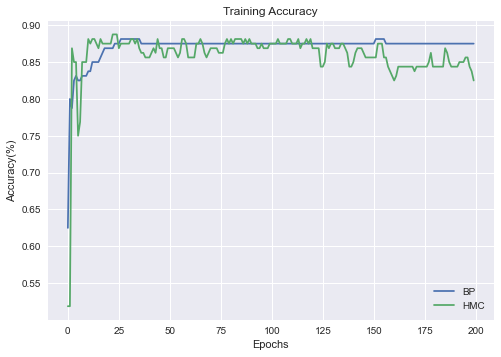

In [16]:
plt.style.use('seaborn')
plt.plot(history_bp.history['accuracy'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['train_acc'], label = 'HMC')
#plt.plot(list(range(epochs)), history_gibbs['acc'], label = 'Gibbs')
plt.title("Training Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.savefig('makemoon_train_acc.pdf')

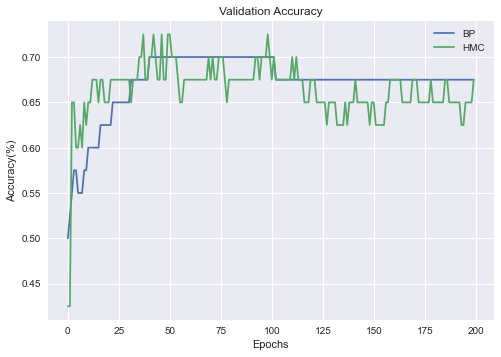

In [10]:
plt.plot(history_bp.history['val_accuracy'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['val_acc'], label = 'HMC')
#plt.plot(list(range(epochs)), history_gibbs['acc'], label = 'Gibbs')
plt.title("Validation Accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy(%)")
plt.legend()
plt.show()

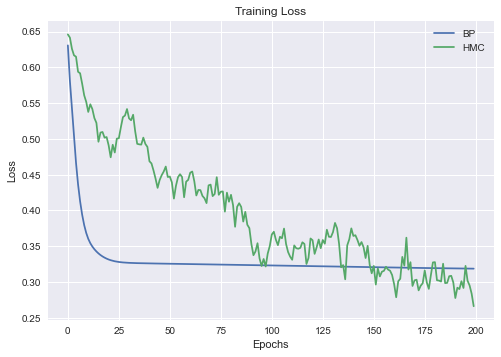

In [11]:
plt.plot(history_bp.history['loss'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['train_loss'], label = 'HMC')
#plt.plot(list(range(epochs)), history_gibbs['acc'], label = 'Gibbs')
plt.title("Training Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

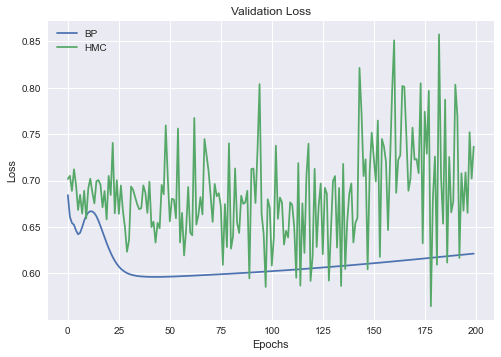

In [12]:
plt.style.use('seaborn')
plt.plot(history_bp.history['val_loss'], label = 'BP')
plt.plot(list(range(epochs)), history_hmc['val_loss'], label = 'HMC')
#plt.plot(list(range(epochs)), history_gibbs['acc'], label = 'Gibbs')
plt.title("Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

ValueError: x and y must have same first dimension, but have shapes (500,) and (1,)

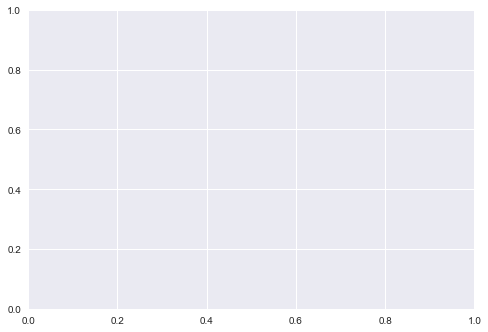

In [13]:
plt.plot(list(range(500)), burnin_loss_hmc, label = 'HMC')
#plt.plot(list(range(500)), tlp_burnin_gibbs, label = 'Gibbs')
plt.title("Burnin Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()